# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [13]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [4]:
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from models import ActorNN, CriticNN
from replay_buffer import ReplayBuffer
from ou_noise import OUNoise
from collections import deque


BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-1              # for soft update of target parameters
ACTOR_LR = 1e-4         # learning rate of the actor 
CRITIC_LR = 1e-4
UPDATE_EVERY = 1        # how often to update the network
UPDATES_NUM = 1
WEIGHT_DECAY = 0
ACTOR_DROP_PROB = 0.
CRITIC_DROP_PROB = 0.2


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def soft_update(target, src, tau):
    for target_param, param in zip(target.parameters(), src.parameters()):
        target_param.detach_()
        target_param.copy_(target_param * (1.0 - tau) + param * tau)
        

class Actor:
    def __init__(self, state_size, action_size, seed, drop_prob=0.):
        self.local = ActorNN(state_size, action_size, seed, drop_prob).to(device)
        self.target = ActorNN(state_size, action_size, seed, drop_prob).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=ACTOR_LR)

    
class Critic:
    def __init__(self, state_size, action_size, seed, drop_prob=0.):
        self.local = CriticNN(state_size, action_size, seed, drop_prob).to(device)
        self.target = CriticNN(state_size, action_size, seed, drop_prob).to(device)
        self.optimizer = optim.Adam(self.local.parameters(),
                                           lr=CRITIC_LR, weight_decay=WEIGHT_DECAY)   

    
class DDPGAgent:
    def __init__(self, state_size, action_size, seed, idx, critic, actor_drop_prob=0., critic_drop_prob=0.):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.idx = idx
        
        self.noise = OUNoise(action_size)
        
        self.actor = Actor(state_size, action_size, seed, actor_drop_prob)
        if critic == None:
            self.critic = Critic(state_size, action_size, seed, critic_drop_prob)
        else:
            print(f'Agent{self.idx} uses shared critic')
            self.critic = critic
        
        soft_update(self.critic.target, self.critic.local, 1.)
        soft_update(self.actor.target, self.actor.local, 1.)
        
        self.t_step = 0
        
        
    def reset(self):
        self.noise.reset()
        self.t_step = 0

        
    def act(self, state, noise=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state

        """
        state = torch.from_numpy(state).float().to(device)
        self.actor.local.eval()
        with torch.no_grad():
            action = self.actor.local(state).cpu().data.numpy()
        self.actor.local.train()
        action += self.noise.sample(self.t_step)*noise
        self.t_step += 1
        return np.clip(action, -1, 1)
    
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        actions_next = self.actor.target(next_states)
        Q_targets_next = self.critic.target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic.local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor.local(states)
        actor_loss = -self.critic.local(states, actions_pred).mean()
        # Minimize the loss
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        # ----------------------- update target networks ----------------------- #
        soft_update(self.critic.target, self.critic.local, TAU)
        soft_update(self.actor.target, self.actor.local, TAU)
        
        
    def checkpoint(self, episode_idx, done=False, best=False, best_idx=0):
        if best:
            if best_idx == self.idx:
                torch.save(self.actor.local.state_dict(), f'checkpoint_actor_best_{episode_idx}.pth')
                torch.save(self.critic.local.state_dict(), f'checkpoint_critic_best_{episode_idx}.pth')
            return
        if done:
            torch.save(self.actor.local.state_dict(), f'checkpoint_actor{self.idx}_done.pth')
            torch.save(self.critic.local.state_dict(), f'checkpoint_critic{self.idx}_done.pth')
        else:
            torch.save(self.actor.local.state_dict(), f'checkpoint_actor{self.idx}_{episode_idx}.pth')
            torch.save(self.critic.local.state_dict(), f'checkpoint_critic{self.idx}_{episode_idx}.pth')
        
        
class MADDPGAgent():
    """Interacts with and learns from the environment."""
    def __init__(self, agents_num, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, device)
        self.critic = Critic(state_size, action_size, seed, CRITIC_DROP_PROB)
        
        self.ddpg_agents = [DDPGAgent(state_size, action_size, seed, i, self.critic, ACTOR_DROP_PROB, CRITIC_DROP_PROB) for i in range(agents_num)]
        
        self.t_step = 0
        
        
    def reset(self):
        for agent in self.ddpg_agents:
            agent.reset()
        
    
    def act(self, state_all_agents, noise=0.):
        actions = [agent.act(state, noise) for agent, state in zip(self.ddpg_agents, state_all_agents)]
        return actions
    
    def step(self, states, actions, rewards, next_states, dones): 
        self.t_step += 1
        
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Learn every UPDATE_EVERY time steps.
        if self.t_step % UPDATE_EVERY == 0:
            for i in range(UPDATES_NUM):
                for agent in self.ddpg_agents:
                    experiences = self.memory.sample()
                    agent.learn(experiences, GAMMA)
                
    
    def checkpoint(self, episode_idx, done=False, best=False, best_idx=0):
        for agent in self.ddpg_agents:
            agent.checkpoint(episode_idx, done, best, best_idx)

In [5]:
agent = MADDPGAgent(num_agents, state_size, action_size, 1)

Agent0 uses shared critic
Agent1 uses shared critic


In [6]:
def maddpg(agent, n_episodes=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """ 
    agents_scores = []                     # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    best_score = 0
    
    noise = 2
    noise_reduction = 0.9999
    
    env_solved = False

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        t_step = 0
        while True:
            actions = agent.act(states, noise)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            t_step += 1
            noise *= noise_reduction
            if np.any(dones):
                break 
        
        max_score = np.max(scores)
        scores_window.append(max_score)
        agents_scores.append(max_score)             # save most recent score
        avg_score = np.mean(scores_window)
        print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}\tBest score: {best_score:.2f}', end="")
        if max_score > best_score:
            best_score = max_score
            agent.checkpoint(i_episode, done=False, best=True, best_idx=np.argmax(scores))
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}\tBest score: {best_score:.2f}')
            agent.checkpoint(i_episode)
        if not env_solved and np.mean(scores_window)>=.5 and i_episode >= 100:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}\tBest score: {best_score:.2f}')
            agent.checkpoint(i_episode, done=True, best=False)
            env_solved = True
    return agents_scores

scores = maddpg(agent)


Episode 100	Average Score: 0.00	Best score: 0.10
Episode 200	Average Score: 0.00	Best score: 0.10
Episode 300	Average Score: 0.02	Best score: 0.10
Episode 400	Average Score: 0.08	Best score: 0.40
Episode 497	Average Score: 0.50	Best score: 2.70
Environment solved in 497 episodes!	Average Score: 0.50	Best score: 2.70
Episode 500	Average Score: 0.55	Best score: 2.70
Episode 600	Average Score: 2.02	Best score: 2.70
Episode 700	Average Score: 1.60	Best score: 2.70
Episode 800	Average Score: 1.19	Best score: 2.70
Episode 900	Average Score: 1.29	Best score: 2.70
Episode 1000	Average Score: 0.97	Best score: 2.70


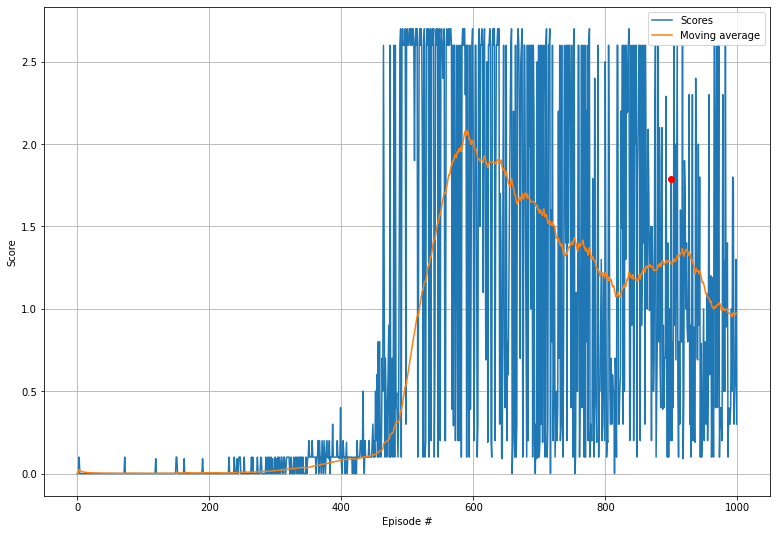

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

df = pd.DataFrame(np.array(scores).reshape(-1, 1), index=np.arange(len(scores)))
mavg = df[0].rolling(window=100, min_periods=0).mean()

ilist = df[df[-100:]>=.5].index.tolist()[-100:]

fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(scores)), scores, label='Scores')
ax.plot(np.arange(len(mavg)), mavg, label='Moving average')
ax.legend()
plt.plot([ilist[0]], [df[0][ilist[0]]], marker='o', color='r', ls='')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid()
plt.show()

## Evaluating the agent

In [5]:
agents_learned = [DDPGAgent(state_size=state_size, action_size=action_size, seed=4, idx=i, critic=None) for i in range(num_agents)]
for agent in agents_learned:
    agent.actor.local.load_state_dict(torch.load('checkpoints/checkpoint_actor_done_sc.pth'))

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = []
        for agent, state in zip(agents_learned, states):   # select an action (for each agent)
            actions.append(agent.act(state))                # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))